# 4. Network Graphs

Graphs may not be the most aesthetic visualizations, but they too can tell a story. For example, graphs are perfect to show the interactions between different items. Multiplex's graph visualizations help you not just plot graphs, but also explain them.

Sometimes called networks, graphs are made up of nodes. Nodes can be connected with each other using edges, which can be both directed and undirected. Multiplex uses matplotlib's scatter and plotting functions to draw nodes and lines, which means that you can style nodes and edges any way you like.

In this notebook, we will go through examples of drawing different kinds of networks from scratch.

> Multiplex uses `networkx` to draw graphs, which means that the package has to be installed. You can learn more about `networkx` [here](https://networkx.github.io/).

In [1]:
%load_ext autoreload
%autoreload 2

import importlib
import matplotlib.pyplot as plt
from networkx import edge_betweenness_centrality
from networkx.algorithms import centrality, community, shortest_paths
import networkx as nx
import os
import pandas as pd
import re
import sys

path = sys.path[0]
path = os.path.join(path, "..")
if path not in sys.path:
    sys.path.insert(1, path)

The first network is the [Marvel Universe Social Network](https://www.kaggle.com/csanhueza/the-marvel-universe-social-network). Yes, even superheros have friends.

This dataset is made up of pairs of superheroes that appeared together in the same comic. Unfortunately, it is _huge_ so we filter out superhero connections that do not appear at least 50 times together.

In [2]:
df = pd.read_csv('data/the-marvel-universe-social-network/hero-network.csv')
df.columns = ('source', 'target')
df = df.groupby(['source', 'target']).size().reset_index()
df.columns = ('source', 'target', 'frequency')
df = df[df['frequency'] > 50]
df = df[df['source'] != df['target']]
df.sort_values(by='frequency', ascending=False)

,source,target,frequency
142513,PATRIOT/JEFF MACE,MISS AMERICA/MADELIN,1267
124772,MISS AMERICA/MADELIN,PATRIOT/JEFF MACE,627
196026,THING/BENJAMIN J. GR,HUMAN TORCH/JOHNNY S,382
85445,HUMAN TORCH/JOHNNY S,MR. FANTASTIC/REED R,366
196250,THING/BENJAMIN J. GR,MR. FANTASTIC/REED R,365
...,...,...,...
109528,LOCKHEED,NIGHTCRAWLER/KURT WA,51
18258,BLACK PANTHER/T'CHAL,THOR/DR. DONALD BLAK,51
84219,HULK/DR. ROBERT BRUC,NIGHTHAWK II/KYLE RI,51
213969,"WATSON-PARKER, MARY","OSBORN, HARRY",51


Multiplex draws networks from `networkx` graphs. Therefore before drawing the Marvel Universe superhero network, we convert the data into a graph. If you have never used `networkx`, worry not. It is extremely simple to create graphs from nodes or edges.

For the sake of the example, we make the dataset smaller by focusing on the 50 most popular superheroes in the dataset.

In [3]:
G = nx.convert_matrix.from_pandas_edgelist(df, 'source', 'target')
degree = sorted(G.degree(), key=lambda hero: hero[1], reverse=True)
top = [ hero for hero, neighbours in degree if neighbours > 2 ][:50]
G = G.subgraph(top)
print(f"{ len(G.nodes) } nodes, { len(G.edges) } edges")

50 nodes, 229 edges


As soon as we create the graph, plotting it is as simple as calling the drawable's `draw_graph` method, using `s` to control the node size. The styling for nodes and edges can be passed separately as dictionaries using the `node_style` and `edge_style` parameters.

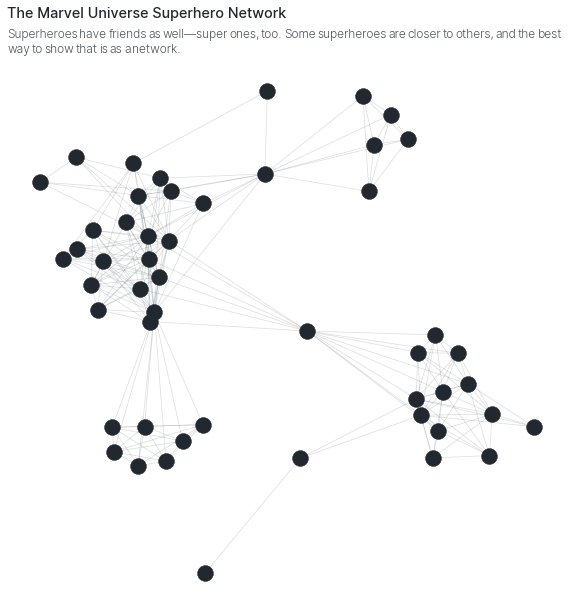

In [4]:
from multiplex import drawable
drawable = importlib.reload(drawable)

plt.style.use(os.path.join(sys.path[0], '..', 'styles', "modern.style"))

figure = plt.figure(figsize=(10, 10))
viz = drawable.Drawable(figure)
node_style = { 'color': 'C0', 'edgecolor': 'C0', 'linewidth': 0.5, 's': 250 }
edge_style = { 'color': 'C0', 'linewidth': 0.75, 'alpha': 0.15 }
viz.draw_graph(G, k=0.5, seed=12,
               node_style=node_style, edge_style=edge_style)

viz.set_title('The Marvel Universe Superhero Network', loc='left')
viz.set_caption("""Superheroes have friends as well—super ones, too.
                   Some superheroes are closer to others, and the best way to show that is as a network.""")
plt.show()

That was easy, wasn't it? With just a few lines of code, we converted data into a network, defined the style and plotted it as a visualization. The visualization, although rudimentary, already shows that some superheroes are closer than others. However, readers have to come up with their own narrative.

What is more interesting is finding out the biggest cluster of superheroes. Before drawing the next network, we partition the graph. Unsurprisingly, the most exclusive superhero club is the Avengers.

In [5]:
def most_central_edge(G):
    """
    Find the most central edge in the given graph.
    
    :param G: The graph on which the algorithm operates.
    :type G: :class:`~networkx.Graph`
    
    :return: The most central edge, made up of the source and edge nodes.
    :rtype: tuple
    """

    centrality = edge_betweenness_centrality(G)
    return max(centrality, key=centrality.get)
    
communities = community.girvan_newman(G, most_valuable_edge=most_central_edge)
"""
Keep getting communities until there are fewer than the square root of the nodes.
"""
partitions = list(next(communities))
while len(partitions) < 20:
    partitions = list(next(communities))

"""
Filter out singleton partitions.
"""
partitions = [ partition for partition in partitions if len(partition) > 1 ]
partitions = sorted(partitions, key=len, reverse=True)
print(f"Largest partition: { ', '.join(superhero.strip().title() for superhero in partitions[0]) }")

Largest partition: Captain America, Wasp/Janet Van Dyne, Vision, Jarvis, Edwin, Black Panther/T'Chal, Quicksilver/Pietro M, Scarlet Witch/Wanda, Thor/Dr. Donald Blak, Hawk, Iron Man/Tony Stark, Ant-Man/Dr. Henry J., Wonder Man/Simon Wil


In the visualization above, we couldn't quite tell which superheroes were the Avengers. This time, we color the Avengers nodes and edges between them in red.

Remember that styling options are passed on using the `node_style` and `edge_style` parameters. However, we can override them for specific nodes and edges by using the `style` attribute, as in the following example.

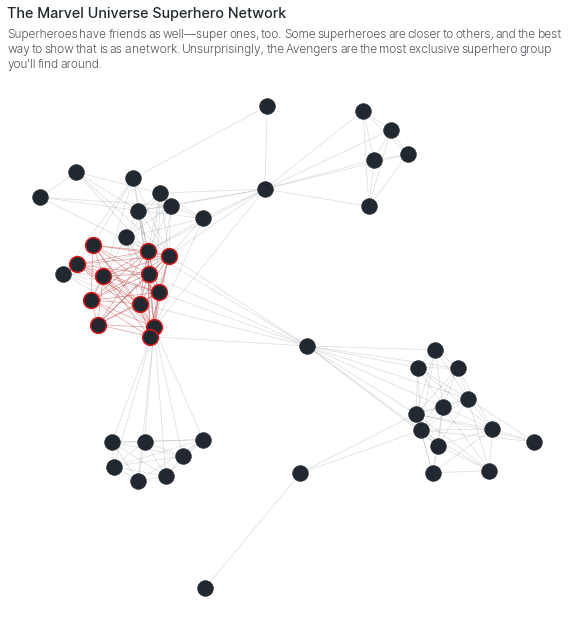

In [6]:
from multiplex import drawable
drawable = importlib.reload(drawable)

plt.style.use(os.path.join(sys.path[0], '..', 'styles', "modern.style"))

"""
Color the Avengers' nodes red.
Also color any edges between the Avengers red.
"""
for node in partitions[0]:
    G.nodes[node]['style'] = { 'color': 'C0', 'edgecolor': 'C1', 'linewidth': 1.5 }
    edges = [ (source, target) for (source, target) in G.edges(node)
             if target in partitions[0] ]
    for edge in edges:
        G.edges[edge]['style'] = { 'alpha': 0.45, 'color': '#BB3633' }

figure = plt.figure(figsize=(10, 10))
viz = drawable.Drawable(figure)
node_style = { 'color': 'C0', 'edgecolor': 'C0', 'linewidth': 0.5, 's': 250 }
edge_style = { 'color': 'C0', 'linewidth': 0.75, 'alpha': 0.15 }
viz.draw_graph(G, k=0.5, seed=12,
               node_style=node_style, edge_style=edge_style)
viz.set_title('The Marvel Universe Superhero Network', loc='left')
viz.set_caption("""Superheroes have friends as well—super ones, too.
                   Some superheroes are closer to others, and the best way to show that is as a network.
                   Unsurprisingly, the Avengers are the most exclusive superhero group you'll find around.""")
plt.show()

That's better, isn't it? Still, it doesn't answer some important questions, like who is part of the Avengers and who leads them, or which other superheroes are almost members. To answer these questions, we find the most central Avenger and calculate the distance from every superhero to them.

In [7]:
S = G.subgraph(partitions[0])
node_centrality = centrality.eigenvector_centrality(S)
center = sorted(node_centrality, key=node_centrality.get, reverse=True)
print(f"Most central Avenger: { center[0].title() }")
distances = { node: len(shortest_paths.generic.shortest_path(G, center[0], node)) for node in G.nodes }

Most central Avenger: Captain America


In the next visualization, we elect the most central Avenger and give them a label. For good measure, we spice up the network by changing the size of every node based on their distance to the Avengers' leader-elect. 

To add labels next to edges, use the `name` attribute, and the `name_style` to change its appearance. You can do the same for edges.

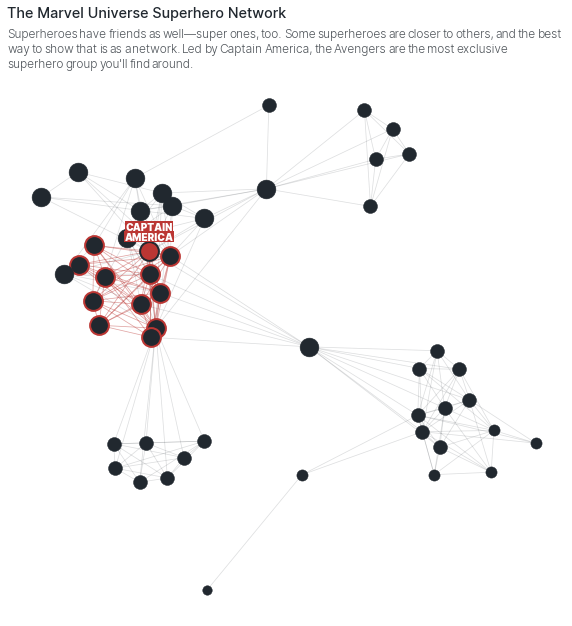

In [8]:
from multiplex import drawable
drawable = importlib.reload(drawable)

plt.style.use(os.path.join(sys.path[0], '..', 'styles', "modern.style"))

"""
Calculate the size of nodes based on their distance from the Avengers' leader.
"""
for node in G.nodes:
    G.nodes[node]['style'] = { 's': 1000 * (1 / max(2, distances[node]) ** 1.5) }

"""
Color in the Avengers' leader to make them stand out.
Also add their name next to the node.
"""
pattern = re.compile('^(.+)?[,\/\[].+?$')
node = center[0]
G.nodes[node]['style'].update({ 'color': '#BB3633', 'edgecolor': 'C0', 'linewidth': 2 })
G.nodes[node]['name'] = pattern.findall(node)[0] if pattern.findall(node) else node
G.nodes[node]['name_style'] = { 'color': 'C2', 'facecolor': '#BB3633', 'lineheight': 1,
                                'fontsize': 10, 'fontweight': 900 }

"""
Go through each Avenger and give them a red edge to make them stand out.
"""
for node in partitions[0]:
    if node == center[0]:
        continue
    G.nodes[node]['style'].update({ 'edgecolor': '#BB3633', 'linewidth': 2 })
    edges = [ (source, target) for (source, target) in G.edges(node)
             if target in partitions[0] ]
    for edge in edges:
        G.edges[edge]['style'] = { 'alpha': 0.45, 'color': '#BB3633' }

figure = plt.figure(figsize=(10, 10))
viz = drawable.Drawable(figure)
node_style = { 'color': 'C0', 'edgecolor': 'C0', 'linewidth': 0.5 }
edge_style = { 'color': 'C0', 'linewidth': 0.75, 'alpha': 0.15 }
viz.draw_graph(G, k=0.5, seed=12,
               node_style=node_style, edge_style=edge_style)

viz.set_title('The Marvel Universe Superhero Network', loc='left')
viz.set_caption(f"""Superheroes have friends as well—super ones, too.
                   Some superheroes are closer to others, and the best way to show that is as a network.
                   Led by { G.nodes[center[0]]['name'].title() }, the Avengers are the most exclusive superhero group you'll find around.""")
plt.show()

You can learn more about graph visualizations, including functionality that was not covered in this tutorial, on [Multiplex's documentation site](https://nicholasmamo.github.io/multiplex-plot/graph.html).